# Evaluation

Extract the following information from the data:
* Successful verifications per prompt ✅
* Successful verifications per temperature ✅
* Successful verifications per prompt per temperature ✅ 
* Successful verifications per attempt (how many successful verifications occurred at each attempt)
* Deltas for successful verification

## ESBMC Output Extraction

Extract source code

In [71]:
import os
from difflib import SequenceMatcher
from contextlib import chdir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
def get_ver_outcome(content: str) -> str:
    if "Failed all attempts..." in content:
        return "VERIFICATION FAILED"
    # Yes, I know it has a typo as of esbmc-ai==0.5.0rc3 -_-
    elif "ESBMC-AI Notice: Successfully verified code" in content:
        return "VERIFICATION SUCCESSFUL"
    else:
        return "UNKNOWN"

def get_attempts_count(content: str) -> int:
    return content.count("Generation:\n")

In [73]:
# Change this value to affect which subdirectory of experiments to use to generate graphs
base_dir = "single_line_latest_only"
temperature_dirs = ["temperature_0.0_results", "temperature_0.4_results", "temperature_0.7_results", "temperature_1.0_results", "temperature_1.3_results"]
temperatures = [0.0, 0.4, 0.7, 1.0, 1.3]
prompt_dirs = ["results-0", "results-1", "results-2", "results-3", "results-4"]

data = []
for temp_dir in temperature_dirs:
    temp_idx = temperature_dirs.index(temp_dir)
    for prompt_dir in prompt_dirs:
        # Get the final number from the result-x dir.
        prompt_idx = int(prompt_dir[-1])
        file_dir = f"{base_dir}/{temp_dir}/{prompt_dir}"
        for file_name in os.listdir(file_dir):
            if file_name.endswith(".c"):
                file_path = f"{file_dir}/{file_name}"
                with open(file_path, "r") as f:
                    content = f.read()
                data.append({
                    "file_name": file_name,
                    "prompt_idx": prompt_idx,
                    "temperature": temperatures[temp_idx],
                    "esbmc_output": content,
                    "path": file_path,
                    "ver_outcome": get_ver_outcome(content),
                    "attempts_count": get_attempts_count(content),
                })

esbmc_df: pd.DataFrame = pd.DataFrame(data=data, columns=["file_name", "prompt_idx", "temperature", "esbmc_output", "path", "ver_outcome", "attempts_count"])
del data

In [74]:
esbmc_df

,file_name,prompt_idx,temperature,esbmc_output,path,ver_outcome,attempts_count
0,cartpole_82_safe.c-amalgamation-94.c,0,0.0,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_0.0_results/re...,VERIFICATION FAILED,5
1,cartpole_23_safe.c-amalgamation-76.c,0,0.0,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_0.0_results/re...,VERIFICATION FAILED,5
2,cartpole_6_safe.c-amalgamation-102.c,0,0.0,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_0.0_results/re...,VERIFICATION FAILED,5
3,cartpole_30_safe.c-amalgamation-73.c,0,0.0,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_0.0_results/re...,VERIFICATION FAILED,5
4,gcas_5_safe.c-amalgamation-149.c,0,0.0,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_0.0_results/re...,VERIFICATION FAILED,5
...,...,...,...,...,...,...,...
2495,cartpole_69_safe.c-amalgamation-102.c,4,1.3,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_1.3_results/re...,VERIFICATION FAILED,5
2496,cartpole_68_safe.c-amalgamation-29.c,4,1.3,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_1.3_results/re...,VERIFICATION FAILED,5
2497,robot_5_safe.c-amalgamation-13.c,4,1.3,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_1.3_results/re...,VERIFICATION FAILED,5
2498,cartpole_24_safe.c-amalgamation-95.c,4,1.3,Loading .env environment variables...\nESBMC-A...,single_line_reverse/temperature_1.3_results/re...,VERIFICATION FAILED,5


### Check Errors

We have some unknowns, need to check if they're all timeouts.

In [75]:
for idx, row in esbmc_df.loc[esbmc_df["ver_outcome"] == "UNKNOWN"].iterrows():
    if "error: ESBMC has timed out..." not in row["esbmc_output"]:
        print("Error in file:", row["path"] + "\n")
        print("".join(row["esbmc_output"].splitlines(True)[-10:]))
        print()

Error in file: single_line_reverse/temperature_1.3_results/results-0/cartpole_46_safe.c-amalgamation-82.c

typedef struct {
^
/tmp/4913956.1.serial.q/esbmc.f859-b5c4-76d4/headers/stdlib.h:50:1: error: unknown type name 'div_t'; did you mean 'ldiv_t'?
div_t div(int numerator, int denominator);
^
/tmp/4913956.1.serial.q/esbmc.f859-b5c4-76d4/headers/stdlib.h:21:3: note: 'ldiv_t' declared here
} ldiv_t;
  ^
ERROR: PARSING ERROR





## Attempts Source Code Extraction

Get the attempts from the output of ESBMC-AI

In [76]:
def get_exp_idx(file_name: str, prompt_idx: int, temperature: float) -> str:
    return (esbmc_df["file_name"] == file_name) & (esbmc_df["prompt_idx"] == prompt_idx) & (esbmc_df["temperature"] == temperature)

def get_esbmc_attempts(esbmc_output: str, max_attempts: int) -> list[tuple[str, str]]:
    attempts = []
    # Before every code output, there is a "Generation:" text
    generation_idx = 0
    for attempt in range(0, max_attempts):
        sc_start_idx = esbmc_output.find("Generation:\n", generation_idx) + len("Generation:\n")
        esbmc_start_idx = esbmc_output.find("ESBMC version 7.4.0 64-bit x86_64 linux", sc_start_idx)
        sc_end_idx = esbmc_start_idx - 1
        esbmc_end_idx = esbmc_output.find("ESBMC-AI Notice:", esbmc_start_idx)
        attempts.append((esbmc_output[sc_start_idx:sc_end_idx], esbmc_output[esbmc_start_idx:esbmc_end_idx]))
    return attempts

In [77]:
data = []
for idx, row in esbmc_df.iterrows():
    file_name = row["file_name"]
    prompt_idx = row["prompt_idx"]
    temperature = row["temperature"]
    esbmc_output = row["esbmc_output"]
    attempts_count = row["attempts_count"]
    path = row["path"]
    attempts = get_esbmc_attempts(esbmc_output, attempts_count)
    for idx, attempt in enumerate(attempts):
        source_code, esbmc_output = attempt
        data.append({
            "file_name": file_name,
            "path": path,
            "prompt_idx": prompt_idx,
            "temperature": temperature,
            "attempt_idx": idx,
            "attempt": source_code,
            "esbmc_output": esbmc_output,
        })

attempts_df: pd.DataFrame = pd.DataFrame(data=data, columns=["file_name", "path", "prompt_idx", "temperature", "attempt_idx", "attempt", "esbmc_output"])
del data

In [78]:
attempts_df

,file_name,path,prompt_idx,temperature,attempt_idx,attempt,esbmc_output
0,cartpole_82_safe.c-amalgamation-94.c,single_line_reverse/temperature_0.0_results/re...,0,0.0,0,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
1,cartpole_82_safe.c-amalgamation-94.c,single_line_reverse/temperature_0.0_results/re...,0,0.0,1,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
2,cartpole_82_safe.c-amalgamation-94.c,single_line_reverse/temperature_0.0_results/re...,0,0.0,2,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
3,cartpole_82_safe.c-amalgamation-94.c,single_line_reverse/temperature_0.0_results/re...,0,0.0,3,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
4,cartpole_82_safe.c-amalgamation-94.c,single_line_reverse/temperature_0.0_results/re...,0,0.0,4,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
...,...,...,...,...,...,...,...
12144,gcas_8_safe.c-amalgamation-6.c,single_line_reverse/temperature_1.3_results/re...,4,1.3,0,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
12145,gcas_8_safe.c-amalgamation-6.c,single_line_reverse/temperature_1.3_results/re...,4,1.3,1,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
12146,gcas_8_safe.c-amalgamation-6.c,single_line_reverse/temperature_1.3_results/re...,4,1.3,2,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...
12147,gcas_8_safe.c-amalgamation-6.c,single_line_reverse/temperature_1.3_results/re...,4,1.3,3,// This file is part of the SV-Benchmarks coll...,ESBMC version 7.4.0 64-bit x86_64 linux\nTarge...


## Evaluation

In [79]:
if not os.path.exists("graphs"):
    os.mkdir("graphs")
with chdir("graphs"):
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)

### Successful Verifications Per Temperature

In [80]:
temperature_groups = esbmc_df.groupby("temperature").indices
# The temperatures array will be used as the group
y_data = {}
for temperature in temperatures:
    # Get the dataframe scoped down to the temperature grouping
    temp_df = esbmc_df.iloc[temperature_groups[temperature]]
    # Count the 
    total = len(temp_df.index)
    outcomes = []
    for outcome in ["VERIFICATION SUCCESSFUL", "VERIFICATION FAILED", "UNKNOWN"]:
        outcomes_group = temp_df.loc[temp_df["ver_outcome"] == outcome]
        outcomes.append(outcomes_group["ver_outcome"].count() / total * 100.0)
    y_data[temperature] = outcomes
y_data

{0.0: [0.0, 98.0, 2.0],
 0.4: [0.4, 96.8, 2.8000000000000003],
 0.7: [1.4000000000000001, 97.8, 0.8],
 1.0: [1.7999999999999998, 94.6, 3.5999999999999996],
 1.3: [2.8000000000000003, 96.2, 1.0]}

In [81]:
len(temp_df.index)

500

<Figure size 640x480 with 0 Axes>

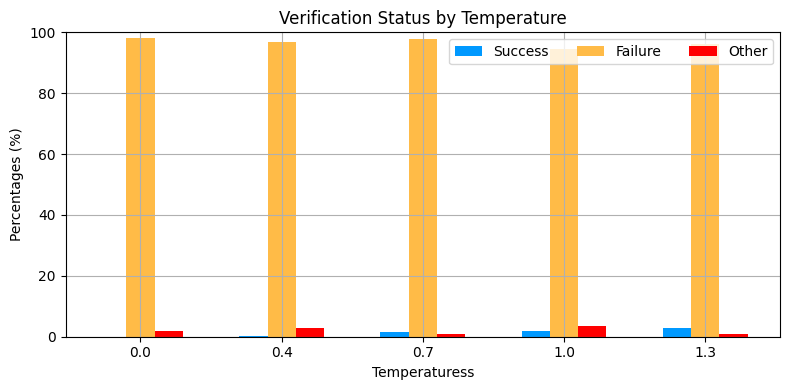

In [82]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(8, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]
failure = [temperature_outcomes[1] for temperature_outcomes in y_data.values()]
other = [temperature_outcomes[2] for temperature_outcomes in y_data.values()]

bar_width = 0.2
index = range(len(temperatures))

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")

plt.xlabel("Temperatures")
plt.ylabel("Percentages (%)")
plt.title("Verification Status by Temperature")
plt.xticks([i + bar_width for i in index], temperatures)
plt.legend(ncols=3)
plt.ylim(0, 100)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_temp_01.png", format="png")
plt.show()

<Figure size 640x480 with 0 Axes>

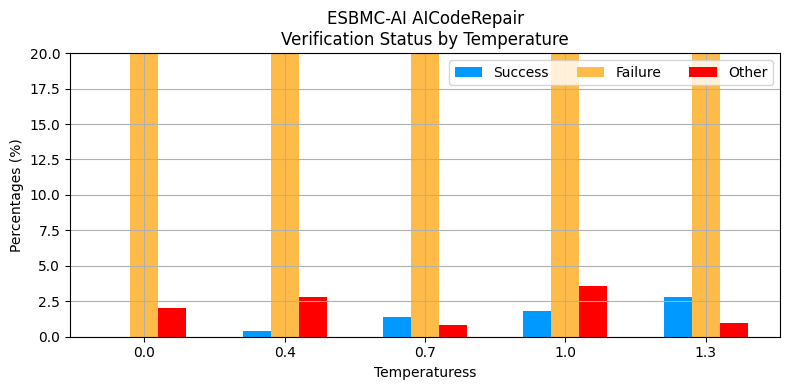

In [83]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(8, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]
failure = [temperature_outcomes[1] for temperature_outcomes in y_data.values()]
other = [temperature_outcomes[2] for temperature_outcomes in y_data.values()]

bar_width = 0.2
index = range(len(temperatures))

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")

plt.xlabel("Temperatures")
plt.ylabel("Percentages (%)")
plt.title("ESBMC-AI AICodeRepair\nVerification Status by Temperature")
plt.xticks([i + bar_width for i in index], temperatures)
plt.legend(ncols=3)
plt.ylim(0, 20)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_temp_02.png", format="png")
plt.show()

Show only the successful verification line

<Figure size 640x480 with 0 Axes>

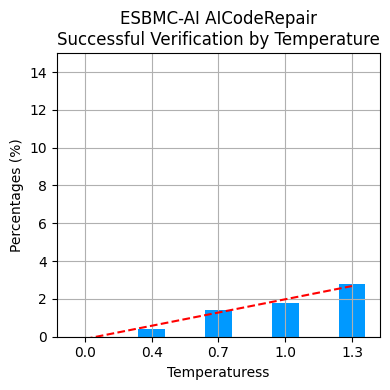

In [84]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(4, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]

bar_width = 0.4
index = range(len(temperatures))

# Calculate the trend line
trend_points = np.polyfit(index, success, 1)
# Evaluate the polinomial and get values
trend_line = np.poly1d(trend_points)

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
# Plot trend line
plt.plot(index, trend_line(index), 'r--', label='Trend Line')

plt.xlabel("Temperatures")
plt.ylabel("Percentages (%)")
plt.title("ESBMC-AI AICodeRepair\nSuccessful Verification by Temperature")
plt.xticks(index, temperatures)
plt.ylim(0, 15)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_temp_03.png", format="png")
plt.show()

### Successful verifications per prompt

In [85]:
prompt_groups = esbmc_df.groupby("prompt_idx")
# The temperatures array will be used as the group
y_data = {}
for prompt_idx, prompt_df in prompt_groups:
    # Count the total
    total = len(prompt_df.index)
    outcomes = []
    for outcome in ["VERIFICATION SUCCESSFUL", "VERIFICATION FAILED", "UNKNOWN"]:
        outcomes_group = prompt_df.loc[prompt_df["ver_outcome"] == outcome]
        outcomes.append(outcomes_group["ver_outcome"].count() / total * 100.0)
    y_data[prompt_idx] = outcomes
y_data

{0: [1.6, 93.0, 5.4],
 1: [0.8, 96.8, 2.4],
 2: [1.2, 98.6, 0.2],
 3: [2.0, 96.39999999999999, 1.6],
 4: [0.8, 98.6, 0.6]}

<Figure size 640x480 with 0 Axes>

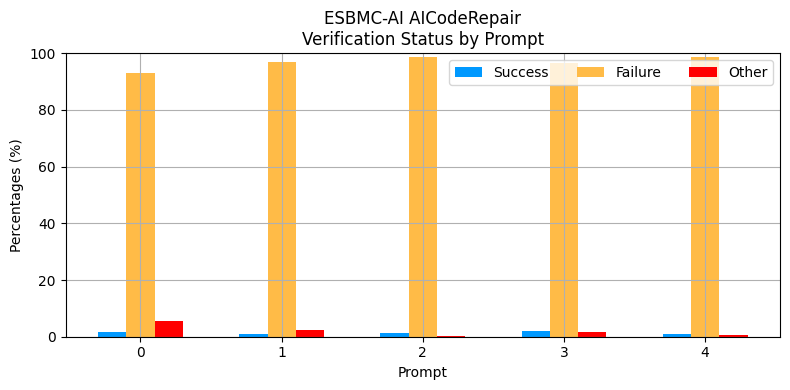

In [86]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(8, 4))

success = [outcomes[0] for outcomes in y_data.values()]
failure = [outcomes[1] for outcomes in y_data.values()]
other = [outcomes[2] for outcomes in y_data.values()]

bar_width = 0.2
index = prompt_groups.groups.keys()

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")

plt.xlabel("Prompt")
plt.ylabel("Percentages (%)")
plt.title("ESBMC-AI AICodeRepair\nVerification Status by Prompt")
plt.xticks([i + bar_width for i in index], index)
plt.legend(ncols=3)
plt.ylim(0, 100)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_prompt_01.png", format="png")
plt.show()

<Figure size 640x480 with 0 Axes>

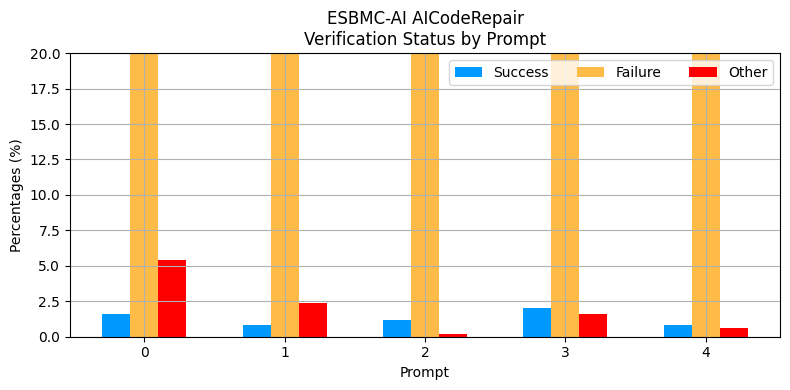

In [87]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(8, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]
failure = [temperature_outcomes[1] for temperature_outcomes in y_data.values()]
other = [temperature_outcomes[2] for temperature_outcomes in y_data.values()]

bar_width = 0.2
index = prompt_groups.groups.keys()

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")

plt.xlabel("Prompt")
plt.ylabel("Percentages (%)")
plt.title("ESBMC-AI AICodeRepair\nVerification Status by Prompt")
plt.xticks([i + bar_width for i in index], index)
plt.legend(ncols=3)
plt.ylim(0, 20)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_prompt_02.png", format="png")
plt.show()

<Figure size 640x480 with 0 Axes>

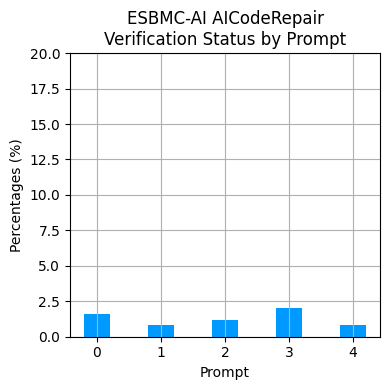

In [88]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(4, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]

bar_width = 0.4
index = prompt_groups.groups.keys()

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")

plt.xlabel("Prompt")
plt.ylabel("Percentages (%)")
plt.title("ESBMC-AI AICodeRepair\nVerification Status by Prompt")
plt.ylim(0, 20)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_prompt_03.png", format="png")
plt.show()

### Successful Verifications Per Prompt Per Temperature

Show the individual performance of each prompt at each temperature

In [89]:
temperature_groups = esbmc_df.groupby("temperature")
# The temperatures array will be used as the group
y_data = {}
for temperature, temp_df in temperature_groups:
    # Iterate prompts
    temp_data = {}
    prompt_groups = temp_df.groupby(["prompt_idx"])
    for prompt_idx, prompt_df in prompt_groups:
        prompt_idx = prompt_idx[0]
        
        # Count the total
        total = len(prompt_df.index)
        outcomes = []
        for outcome in ["VERIFICATION SUCCESSFUL", "VERIFICATION FAILED", "UNKNOWN"]:
            outcomes_group = prompt_df.loc[prompt_df["ver_outcome"] == outcome]
            outcomes.append(outcomes_group["ver_outcome"].count() / total * 100.0)
        temp_data[prompt_idx] = outcomes
    y_data[temperature] = temp_data
y_data

{0.0: {0: [0.0, 92.0, 8.0],
  1: [0.0, 100.0, 0.0],
  2: [0.0, 100.0, 0.0],
  3: [0.0, 100.0, 0.0],
  4: [0.0, 98.0, 2.0]},
 0.4: {0: [0.0, 90.0, 10.0],
  1: [1.0, 98.0, 1.0],
  2: [0.0, 100.0, 0.0],
  3: [1.0, 96.0, 3.0],
  4: [0.0, 100.0, 0.0]},
 0.7: {0: [1.0, 99.0, 0.0],
  1: [0.0, 100.0, 0.0],
  2: [3.0, 97.0, 0.0],
  3: [2.0, 95.0, 3.0],
  4: [1.0, 98.0, 1.0]},
 1.0: {0: [2.0, 91.0, 7.000000000000001],
  1: [0.0, 90.0, 10.0],
  2: [2.0, 97.0, 1.0],
  3: [4.0, 96.0, 0.0],
  4: [1.0, 99.0, 0.0]},
 1.3: {0: [5.0, 93.0, 2.0],
  1: [3.0, 96.0, 1.0],
  2: [1.0, 99.0, 0.0],
  3: [3.0, 95.0, 2.0],
  4: [2.0, 98.0, 0.0]}}

<Figure size 640x480 with 0 Axes>

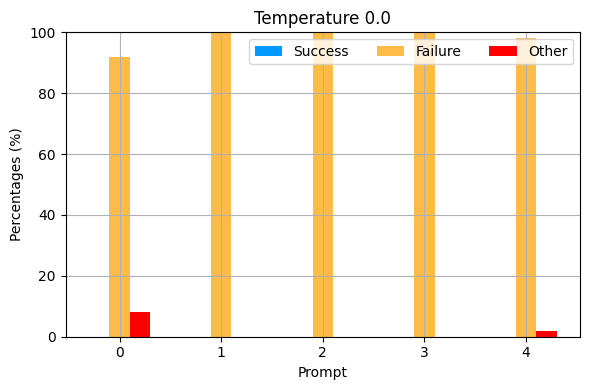

<Figure size 640x480 with 0 Axes>

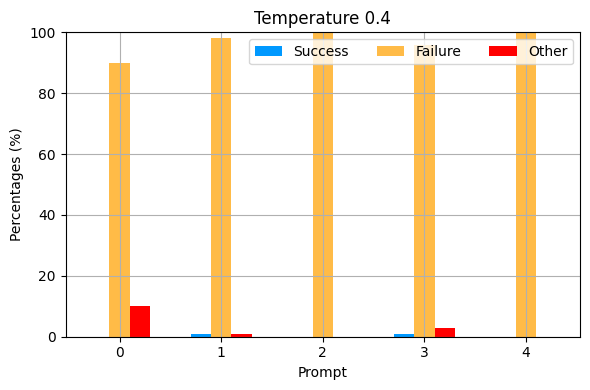

<Figure size 640x480 with 0 Axes>

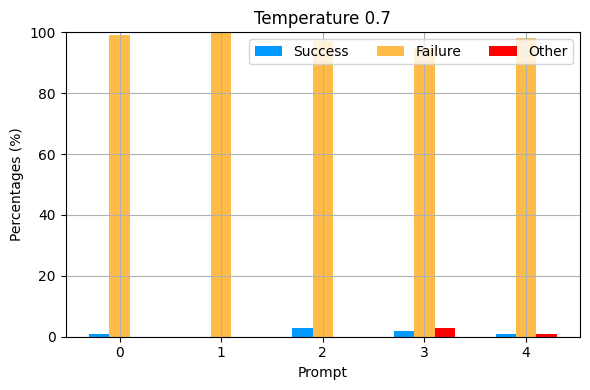

<Figure size 640x480 with 0 Axes>

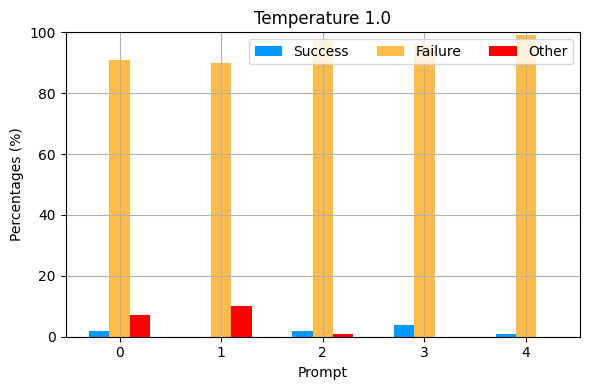

<Figure size 640x480 with 0 Axes>

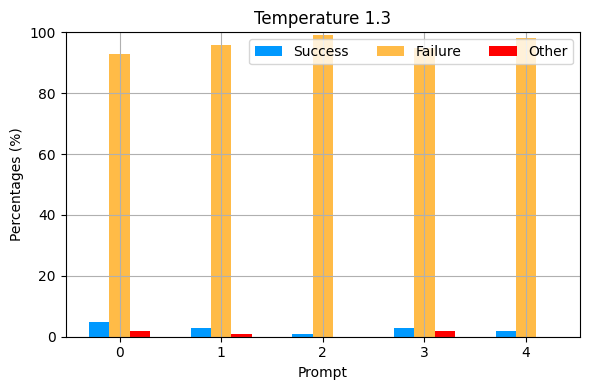

In [90]:
# Plotting the grouped box plot
for temperature in temperatures:
    plt.clf()
    plt.figure(figsize=(6, 4))
    
    success = [outcomes[0] for outcomes in y_data[temperature].values()]
    failure = [outcomes[1] for outcomes in y_data[temperature].values()]
    other = [outcomes[2] for outcomes in y_data[temperature].values()]

    bar_width = 0.2
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
    plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")
    
    plt.title(f"Temperature {temperature}")
    plt.xticks([i + bar_width for i in index], index)
    plt.ylim(0, 100)
    plt.xlabel("Prompt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()
    
    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_prompt_per_temp_01_{temperature}.png", format="png")
    plt.show()

<Figure size 640x480 with 0 Axes>

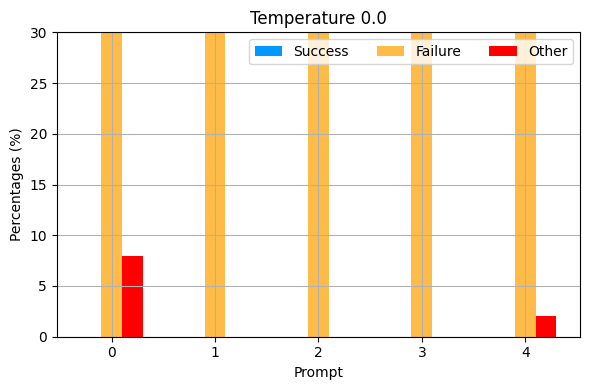

<Figure size 640x480 with 0 Axes>

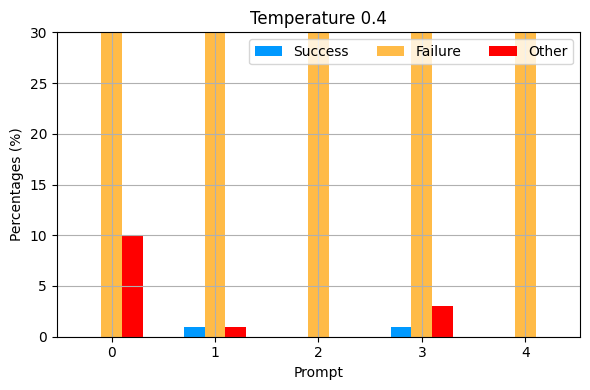

<Figure size 640x480 with 0 Axes>

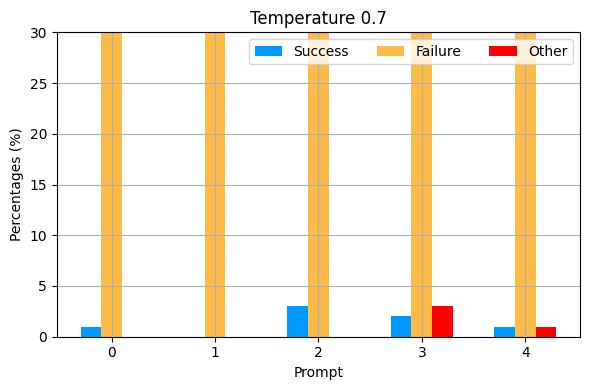

<Figure size 640x480 with 0 Axes>

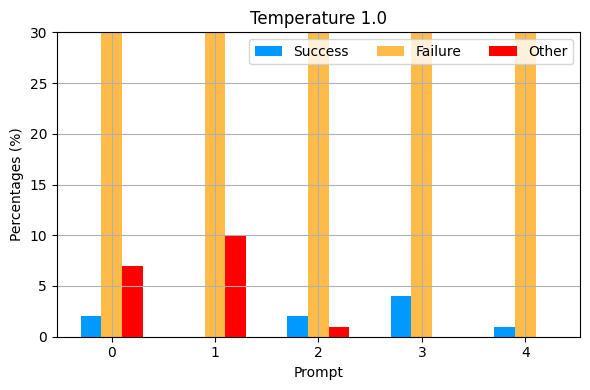

<Figure size 640x480 with 0 Axes>

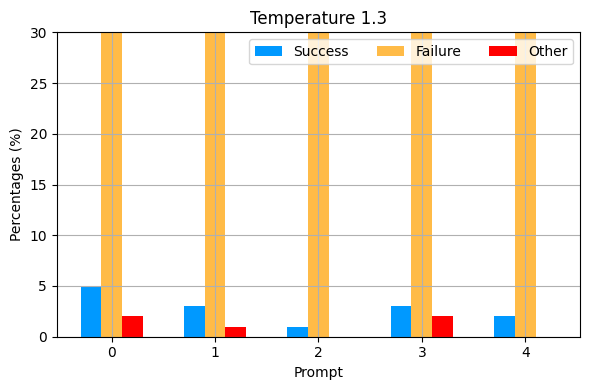

In [91]:
# Plotting the grouped box plot
for temperature in temperatures:
    plt.clf()
    plt.figure(figsize=(6, 4))
    
    success = [outcomes[0] for outcomes in y_data[temperature].values()]
    failure = [outcomes[1] for outcomes in y_data[temperature].values()]
    other = [outcomes[2] for outcomes in y_data[temperature].values()]

    bar_width = 0.2
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
    plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")
    
    plt.title(f"Temperature {temperature}")
    plt.xticks([i + bar_width for i in index], index)
    plt.ylim(0, 30)
    plt.xlabel("Prompt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()
    
    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_prompt_per_temp_02_{temperature}.png", format="png")
    plt.show()

<Figure size 640x480 with 0 Axes>

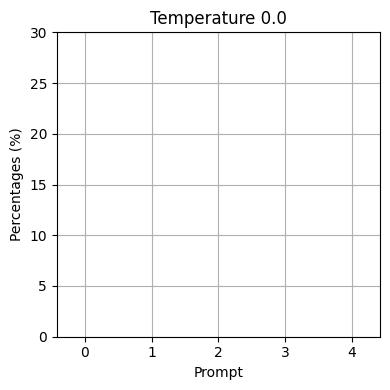

<Figure size 640x480 with 0 Axes>

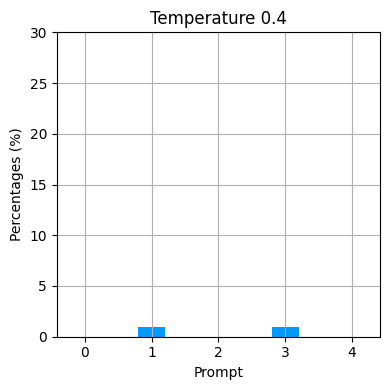

<Figure size 640x480 with 0 Axes>

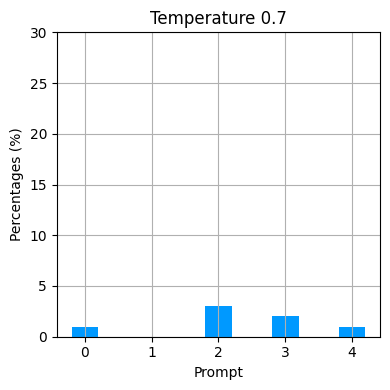

<Figure size 640x480 with 0 Axes>

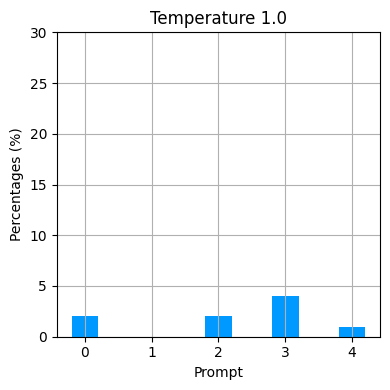

<Figure size 640x480 with 0 Axes>

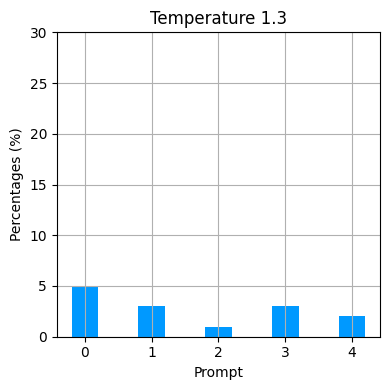

In [92]:
# Plotting the grouped box plot
for temperature in temperatures:
    plt.clf()
    plt.figure(figsize=(4, 4))
    
    success = [outcomes[0] for outcomes in y_data[temperature].values()]

    bar_width = 0.4
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    
    plt.title(f"Temperature {temperature}")
    plt.ylim(0, 30)
    plt.xlabel("Prompt")
    plt.ylabel("Percentages (%)")
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_prompt_per_temp_03_{temperature}.png", format="png")
    plt.show()

### Successful verifications per attempt

This measures how many successful verifications occurred at each attempt

In [93]:
attempt_groups = attempts_df.groupby("attempt_idx")
total = len(esbmc_df.index)
y_data = {}
for attempt_idx, attempt_df in attempt_groups:
    # Count the total attempts of the index
    # total = len(attempt_df.index)
    # Get for each attempt idx, how many successful operations at that index it has.
    outcomes = []
    for outcome in ["VERIFICATION SUCCESSFUL", "VERIFICATION FAILED", "UNKNOWN"]:
        # Merge on path using the attempt_df as the main frame.
        merged_df = attempt_df.merge(esbmc_df, on='path', how='left')
        outcomes_group = merged_df.loc[merged_df["ver_outcome"] == outcome]
        outcomes.append(outcomes_group["ver_outcome"].count() / total * 100.0)
    y_data[attempt_idx] = outcomes
y_data

{0: [1.28, 96.67999999999999, 0.4],
 1: [0.44, 96.67999999999999, 0.12],
 2: [0.08, 96.67999999999999, 0.12],
 3: [0.0, 96.67999999999999, 0.08],
 4: [0.0, 96.67999999999999, 0.04]}

<Figure size 640x480 with 0 Axes>

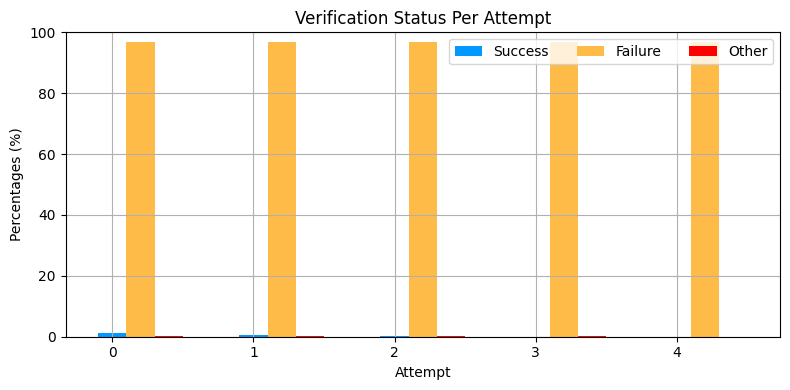

In [94]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(8, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]
failure = [temperature_outcomes[1] for temperature_outcomes in y_data.values()]
other = [temperature_outcomes[2] for temperature_outcomes in y_data.values()]

bar_width = 0.2
index = range(len(attempt_groups))

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")

plt.xlabel("Attempt")
plt.ylabel("Percentages (%)")
plt.title("Verification Status Per Attempt")
plt.xticks(index)
plt.legend(ncols=3)
plt.ylim(0, 100)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_attempt_01.png", format="png")
plt.show()

<Figure size 640x480 with 0 Axes>

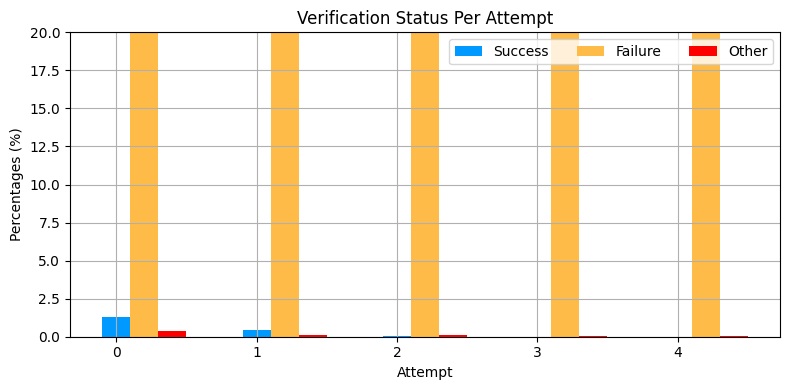

In [95]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(8, 4))

success = [temperature_outcomes[0] for temperature_outcomes in y_data.values()]
failure = [temperature_outcomes[1] for temperature_outcomes in y_data.values()]
other = [temperature_outcomes[2] for temperature_outcomes in y_data.values()]

bar_width = 0.2
index = range(len(attempt_groups))

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")

plt.xlabel("Attempt")
plt.ylabel("Percentages (%)")
plt.title("Verification Status Per Attempt")
plt.xticks(index)
plt.legend(ncols=3)
plt.ylim(0, 20)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_attempt_02.png", format="png")
plt.show()

<Figure size 640x480 with 0 Axes>

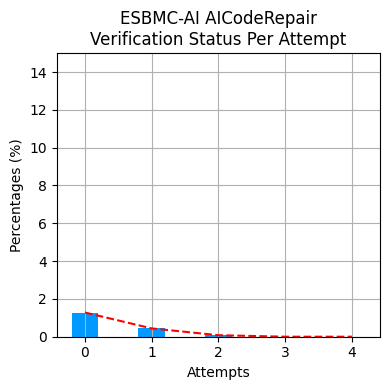

In [96]:
# Plotting the grouped box plot
plt.clf()
plt.figure(figsize=(4, 4))

success = [values[0] for values in y_data.values()]

bar_width = 0.4
index = range(len(attempt_groups))

# Calculate the trend line
trend_points = np.polyfit(index, success, 4)
# Evaluate the polinomial and get values
trend_line = np.poly1d(trend_points)

plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
# Plot trend line
plt.plot(index, trend_line(index), 'r--', label='Trend Line')

plt.xlabel("Attempts")
plt.ylabel("Percentages (%)")
plt.title("ESBMC-AI AICodeRepair\nVerification Status Per Attempt")
plt.xticks(index)
plt.ylim(0, 15)
plt.grid()

plt.tight_layout()
plt.savefig(f"graphs/{base_dir}/successful_per_attempt_03.png", format="png")
plt.show()

### Successful Verifications Per Attempt Per Temperature

In [97]:
temperature_groups = attempts_df.groupby("temperature")
totals = {temp: len(df.index) for temp, df in esbmc_df.groupby("temperature")}
# The temperatures array will be used as the group
y_data = {}
for temperature, temp_df in temperature_groups:
    # Iterate over the attempts
    attempt_groups = temp_df.groupby("attempt_idx")
    attempts_data = {}
    total = totals[temperature]
    for attempt_idx, attempt_df in attempt_groups:
        # Count the total attempts of the index
        # total = len(attempt_df.index)
        # Get for each attempt idx, how many successful operations at that index it has.
        outcomes = []
        for outcome in ["VERIFICATION SUCCESSFUL", "VERIFICATION FAILED", "UNKNOWN"]:
            # Merge on path using the attempt_df as the main frame.
            merged_df = attempt_df.merge(esbmc_df, on='path', how='left')
            outcomes_group = merged_df.loc[merged_df["ver_outcome"] == outcome]
            outcomes.append(outcomes_group["ver_outcome"].count() / total * 100.0)
        attempts_data[attempt_idx] = outcomes
    y_data[temperature] = attempts_data
y_data

{0.0: {0: [0.0, 98.0, 0.4],
  1: [0.0, 98.0, 0.2],
  2: [0.0, 98.0, 0.2],
  3: [0.0, 98.0, 0.2],
  4: [0.0, 98.0, 0.2]},
 0.4: {0: [0.4, 96.8, 0.2],
  1: [0.2, 96.8, 0.2],
  2: [0.2, 96.8, 0.2],
  3: [0.0, 96.8, 0.2],
  4: [0.0, 96.8, 0.0]},
 0.7: {0: [1.4000000000000001, 97.8, 0.2],
  1: [0.2, 97.8, 0.0],
  2: [0.0, 97.8, 0.0],
  3: [0.0, 97.8, 0.0],
  4: [0.0, 97.8, 0.0]},
 1.0: {0: [1.7999999999999998, 94.6, 0.4],
  1: [0.4, 94.6, 0.0],
  2: [0.0, 94.6, 0.0],
  3: [0.0, 94.6, 0.0],
  4: [0.0, 94.6, 0.0]},
 1.3: {0: [2.8000000000000003, 96.2, 0.8],
  1: [1.4000000000000001, 96.2, 0.2],
  2: [0.2, 96.2, 0.2],
  3: [0.0, 96.2, 0.0],
  4: [0.0, 96.2, 0.0]}}

<Figure size 640x480 with 0 Axes>

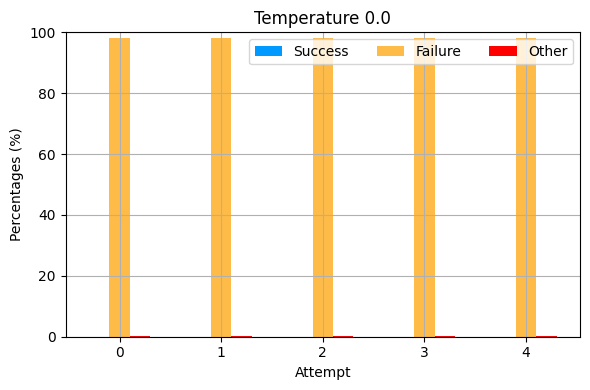

<Figure size 640x480 with 0 Axes>

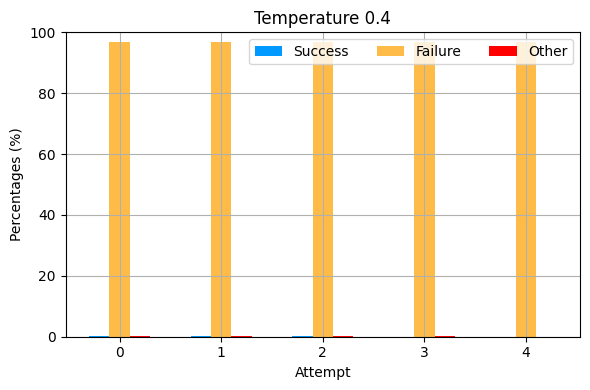

<Figure size 640x480 with 0 Axes>

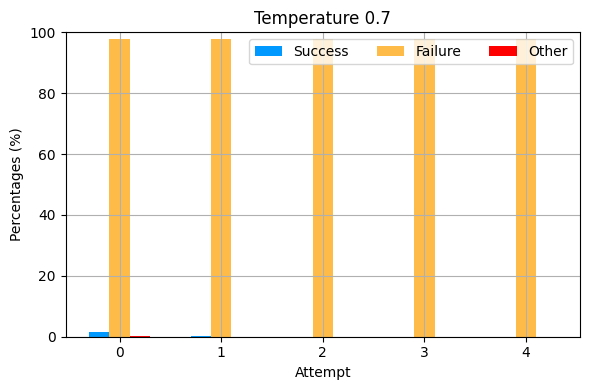

<Figure size 640x480 with 0 Axes>

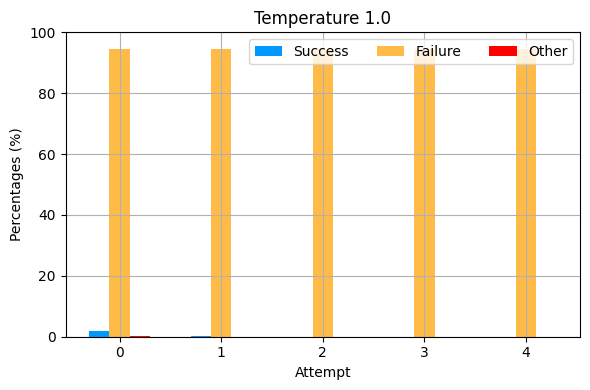

<Figure size 640x480 with 0 Axes>

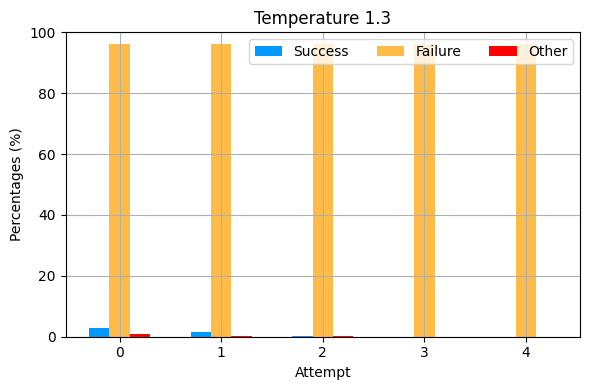

In [98]:
# Plotting the grouped box plot
for temperature in temperatures:
    plt.clf()
    plt.figure(figsize=(6, 4))
    
    success = [outcomes[0] for outcomes in y_data[temperature].values()]
    failure = [outcomes[1] for outcomes in y_data[temperature].values()]
    other = [outcomes[2] for outcomes in y_data[temperature].values()]

    bar_width = 0.2
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
    plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")
    
    plt.title(f"Temperature {temperature}")
    plt.xticks([i + bar_width for i in index], index)
    plt.ylim(0, 100)
    plt.xlabel("Attempt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_attempt_per_temp_01_{temperature}.png", format="png")
    plt.show()

<Figure size 640x480 with 0 Axes>

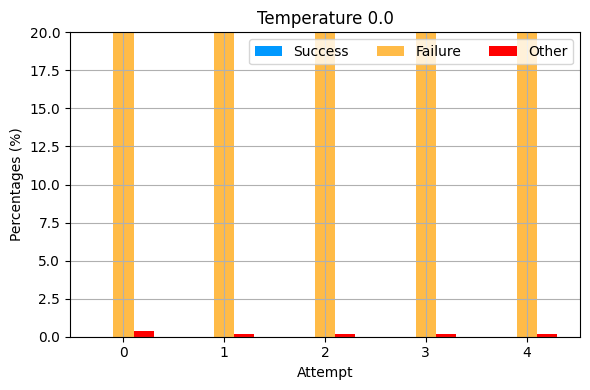

<Figure size 640x480 with 0 Axes>

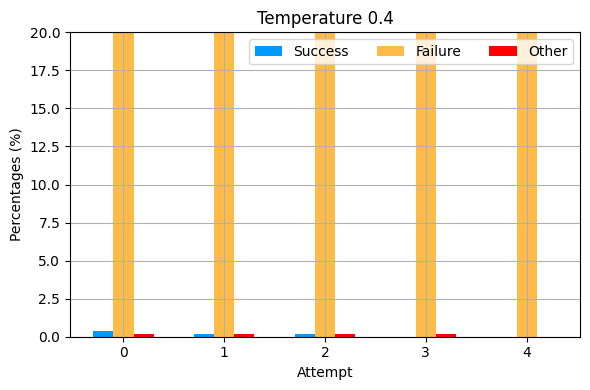

<Figure size 640x480 with 0 Axes>

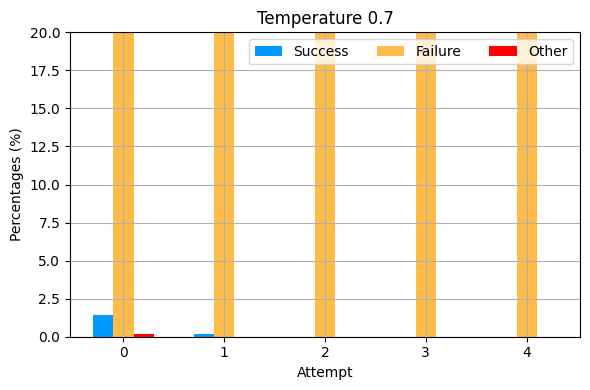

<Figure size 640x480 with 0 Axes>

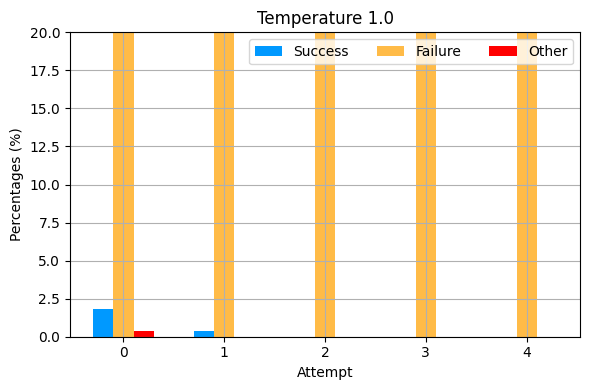

<Figure size 640x480 with 0 Axes>

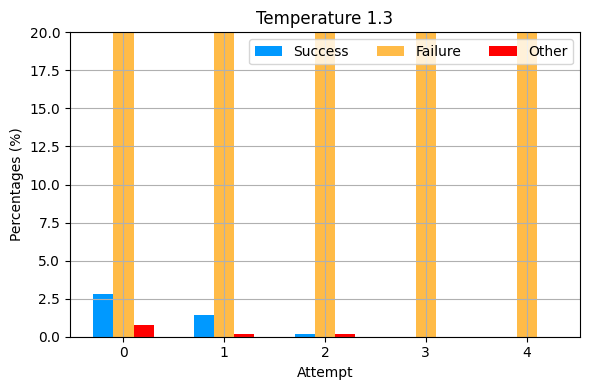

In [99]:
# Plotting the grouped box plot

for temperature in temperatures:
    plt.clf()
    plt.figure(figsize=(6, 4))
    
    success = [outcomes[0] for outcomes in y_data[temperature].values()]
    failure = [outcomes[1] for outcomes in y_data[temperature].values()]
    other = [outcomes[2] for outcomes in y_data[temperature].values()]

    bar_width = 0.2
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
    plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")
    
    plt.title(f"Temperature {temperature}")
    plt.xticks([i + bar_width for i in index], index)
    plt.ylim(0, 20)
    plt.xlabel("Attempt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_attempt_per_temp_02_{temperature}.png", format="png")
    plt.show()

<Figure size 640x480 with 0 Axes>

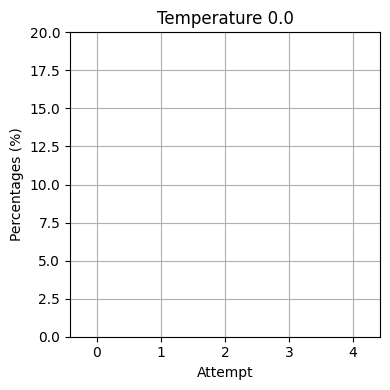

<Figure size 640x480 with 0 Axes>

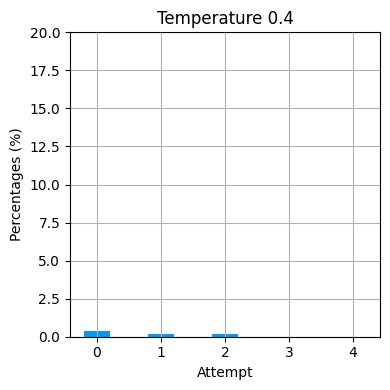

<Figure size 640x480 with 0 Axes>

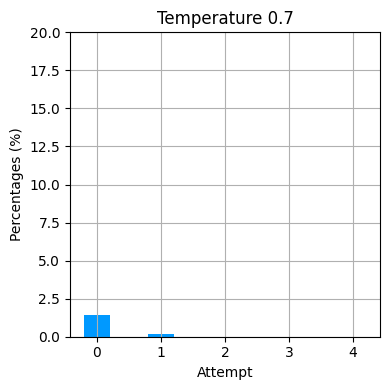

<Figure size 640x480 with 0 Axes>

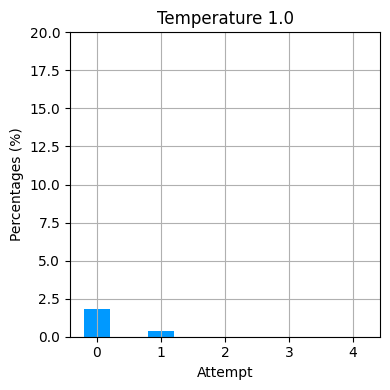

<Figure size 640x480 with 0 Axes>

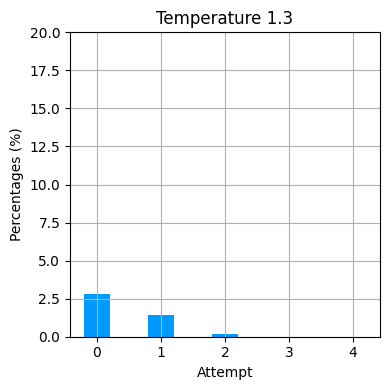

In [100]:
# Plotting the grouped box plot
for temperature in temperatures:
    plt.clf()
    plt.figure(figsize=(4, 4))
    
    success = [outcomes[0] for outcomes in y_data[temperature].values()]

    bar_width = 0.4
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    
    plt.title(f"Temperature {temperature}")
    plt.ylim(0, 20)
    plt.xlabel("Attempt")
    plt.ylabel("Percentages (%)")
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_attempt_per_temp_03_{temperature}.png", format="png")
    plt.show()

### Successful Verifications Per Attempt Per Prompt (Temperature 0.0)

In [101]:
# Do this only for temp 0 since we will have WAY too much data.
temperature = 0.0
temp_df = attempts_df.groupby("temperature").get_group(temperature)
# The temperatures array will be used as the group
y_data = {}
# Iterate over the prompts
prompt_groups = temp_df.groupby("prompt_idx")
for prompt_idx, prompt_df in prompt_groups:
    prompt_data = {}
    attempt_groups = prompt_df.groupby("attempt_idx")
    # Get the totals, which are the samples of the current temperature
    temp_totals_df = esbmc_df.groupby("temperature").get_group(temperature)
    total = len(temp_totals_df.loc[temp_totals_df["prompt_idx"] == prompt_idx].index)
    for attempt_idx, attempt_df in attempt_groups:
        # Count the total attempts of the index
        # total = len(attempt_df.index)
        # Get for each attempt idx, how many successful operations at that index it has.
        outcomes = []
        # Get verification outcome
        for outcome in ["VERIFICATION SUCCESSFUL", "VERIFICATION FAILED", "UNKNOWN"]:
            # Merge on path using the attempt_df as the main frame.
            merged_df = attempt_df.merge(esbmc_df, on='path', how='left')
            outcomes_group = merged_df.loc[merged_df["ver_outcome"] == outcome]
            outcomes.append(outcomes_group["ver_outcome"].count() / total * 100.0)
        prompt_data[attempt_idx] = outcomes
    y_data[prompt_idx] = prompt_data


The data is multi-layered. It all is temperature 0.0 since that seems to perform the best. The first index is the prompt, there are 5 prompt groups ranging from 0 to 4. Each prompt group has 5 attempts labeled from 0 to 4. Each attempt has 3 elements for SUCCESS, FAILURE, and UNKNOWN respectively.

In [102]:
y_data

{0: {0: [0.0, 92.0, 0.0],
  1: [0.0, 92.0, 0.0],
  2: [0.0, 92.0, 0.0],
  3: [0.0, 92.0, 0.0],
  4: [0.0, 92.0, 0.0]},
 1: {0: [0.0, 100.0, 0.0],
  1: [0.0, 100.0, 0.0],
  2: [0.0, 100.0, 0.0],
  3: [0.0, 100.0, 0.0],
  4: [0.0, 100.0, 0.0]},
 2: {0: [0.0, 100.0, 0.0],
  1: [0.0, 100.0, 0.0],
  2: [0.0, 100.0, 0.0],
  3: [0.0, 100.0, 0.0],
  4: [0.0, 100.0, 0.0]},
 3: {0: [0.0, 100.0, 0.0],
  1: [0.0, 100.0, 0.0],
  2: [0.0, 100.0, 0.0],
  3: [0.0, 100.0, 0.0],
  4: [0.0, 100.0, 0.0]},
 4: {0: [0.0, 98.0, 2.0],
  1: [0.0, 98.0, 1.0],
  2: [0.0, 98.0, 1.0],
  3: [0.0, 98.0, 1.0],
  4: [0.0, 98.0, 1.0]}}

<Figure size 640x480 with 0 Axes>

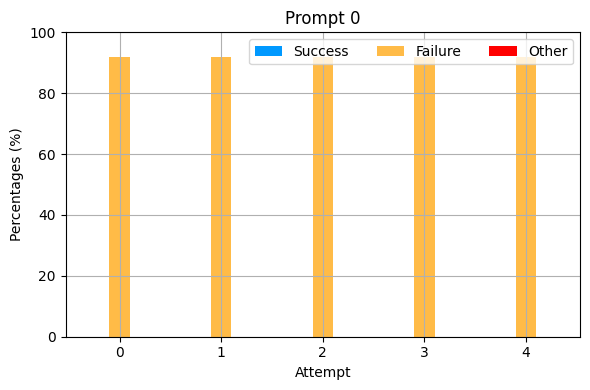

<Figure size 640x480 with 0 Axes>

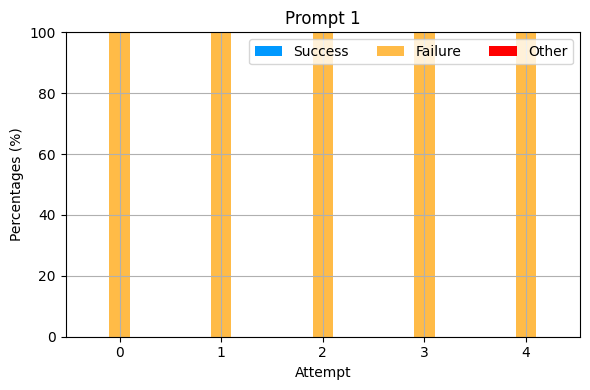

<Figure size 640x480 with 0 Axes>

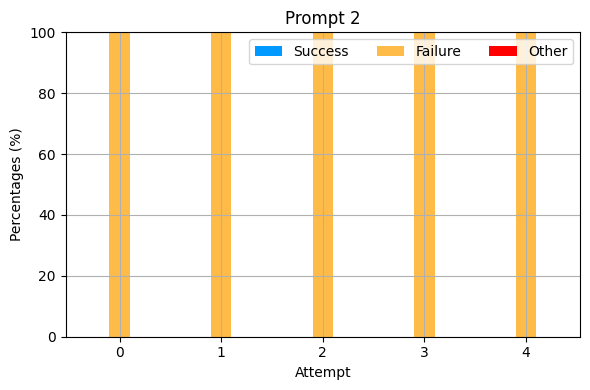

<Figure size 640x480 with 0 Axes>

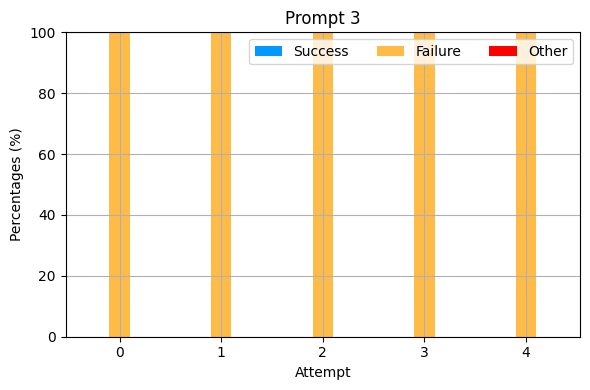

<Figure size 640x480 with 0 Axes>

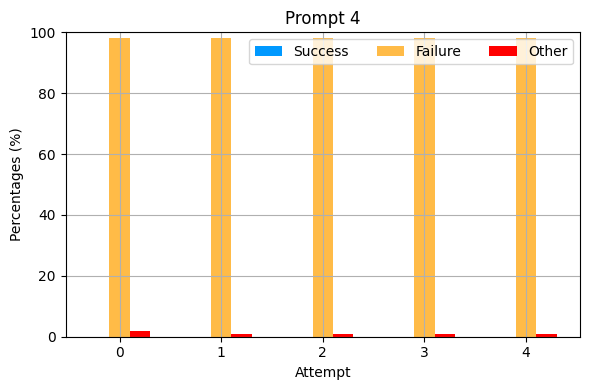

In [103]:
# Plotting the grouped box plot
for prompt_idx in prompt_groups.indices.keys():
    plt.clf()
    plt.figure(figsize=(6, 4))
    
    attempt_data = y_data[prompt_idx]
    
    success = [outcomes[0] for outcomes in attempt_data.values()]
    failure = [outcomes[1] for outcomes in attempt_data.values()]
    other = [outcomes[2] for outcomes in attempt_data.values()]

    bar_width = 0.2
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
    plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")
    
    plt.title(f"Prompt {prompt_idx}")
    plt.xticks([i + bar_width for i in index], index)
    plt.ylim(0, 100)
    plt.xlabel("Attempt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_attempt_per_prompt_01_{prompt_idx}.png", format="png")
    plt.show()

<Figure size 640x480 with 0 Axes>

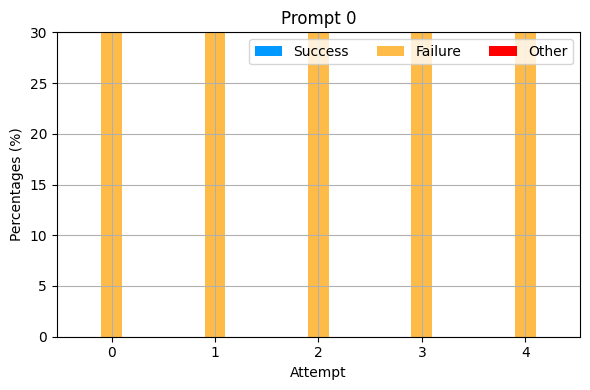

<Figure size 640x480 with 0 Axes>

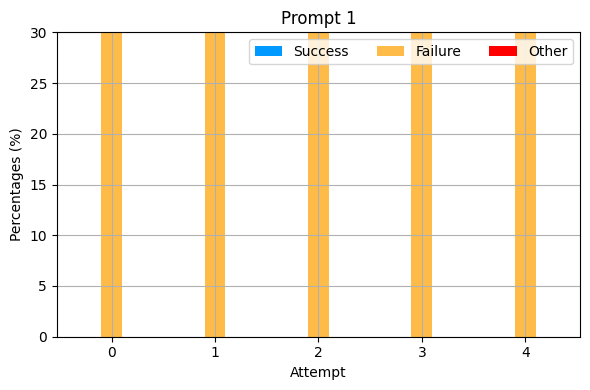

<Figure size 640x480 with 0 Axes>

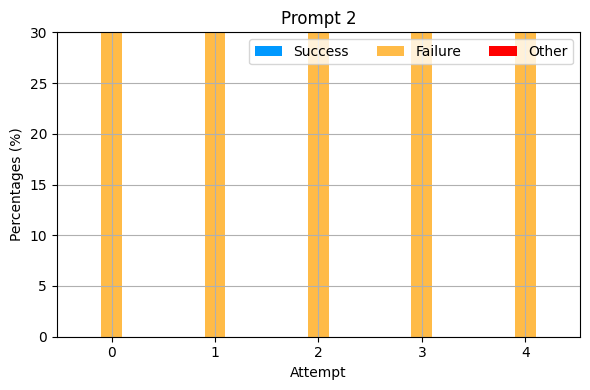

<Figure size 640x480 with 0 Axes>

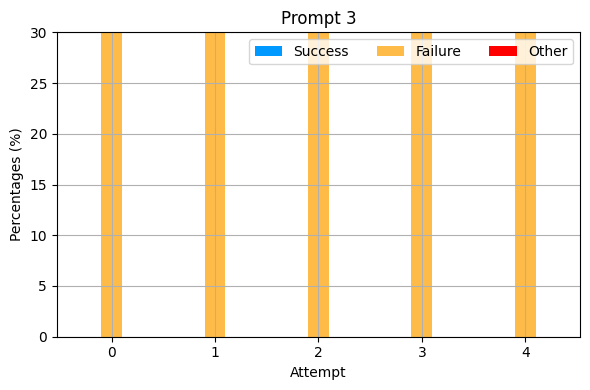

<Figure size 640x480 with 0 Axes>

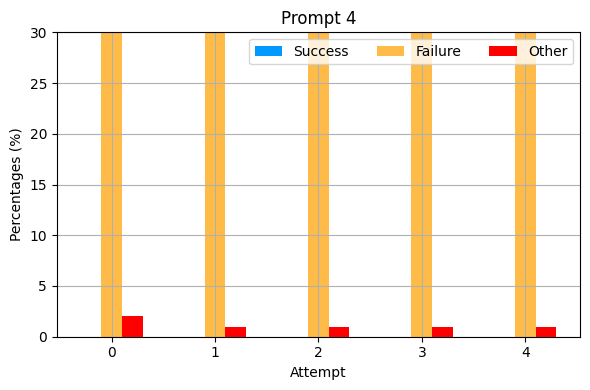

In [104]:
# Plotting the grouped box plot

for prompt_idx in prompt_groups.indices.keys():
    plt.clf()
    plt.figure(figsize=(6, 4))
    
    attempt_data = y_data[prompt_idx]
    
    success = [outcomes[0] for outcomes in attempt_data.values()]
    failure = [outcomes[1] for outcomes in attempt_data.values()]
    other = [outcomes[2] for outcomes in attempt_data.values()]

    bar_width = 0.2
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    plt.bar([i + bar_width for i in index], failure, width=bar_width, label="Failure", color="#ffbb47")
    plt.bar([i + 2 * bar_width for i in index], other, width=bar_width, label="Other", color="r")
    
    plt.title(f"Prompt {prompt_idx}")
    plt.xticks([i + bar_width for i in index], index)
    plt.ylim(0, 30)
    plt.xlabel("Attempt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_attempt_per_prompt_02_{prompt_idx}.png", format="png")
    plt.show()

<Figure size 640x480 with 0 Axes>

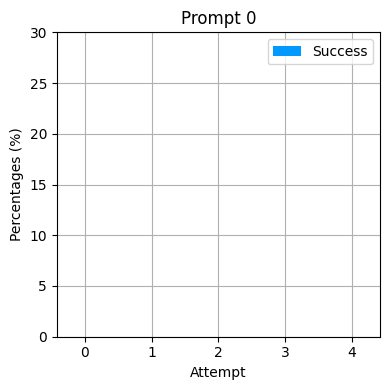

<Figure size 640x480 with 0 Axes>

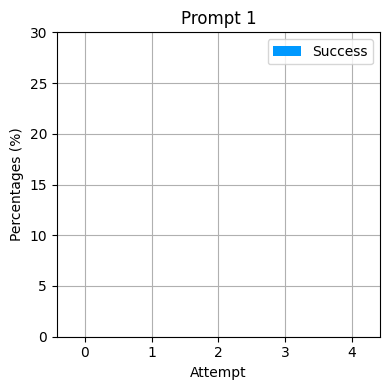

<Figure size 640x480 with 0 Axes>

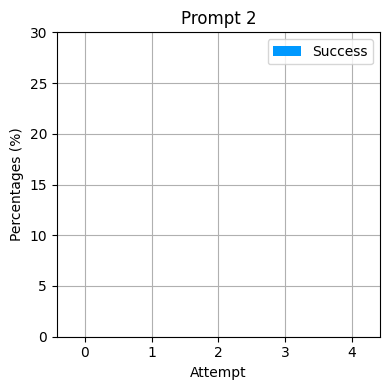

<Figure size 640x480 with 0 Axes>

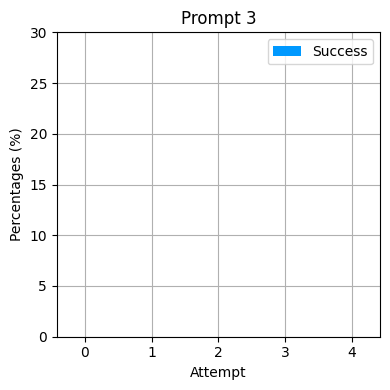

<Figure size 640x480 with 0 Axes>

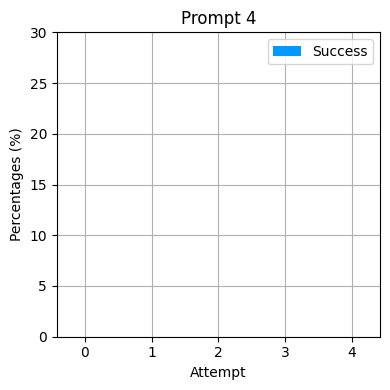

In [105]:
# Plotting the grouped box plot

for prompt_idx in prompt_groups.indices.keys():
    plt.clf()
    plt.figure(figsize=(4, 4))
    
    attempt_data = y_data[prompt_idx]
    
    success = [outcomes[0] for outcomes in attempt_data.values()]

    bar_width = 0.4
    index = prompt_groups.groups.keys()

    plt.bar(index, success, width=bar_width, label="Success", color="#0099ff")
    
    plt.title(f"Prompt {prompt_idx}")
    plt.ylim(0, 30)
    plt.xlabel("Attempt")
    plt.ylabel("Percentages (%)")
    plt.legend(ncols=3)
    plt.grid()
    
    plt.tight_layout()
    plt.savefig(f"graphs/{base_dir}/successful_by_attempt_per_prompt_03_{prompt_idx}.png", format="png")
    plt.show()

## Similarity

Now that I think about it, the entire sample is patched, so likely the similarity is very high...

### Temperature 0.0 Prompt 0